In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import seaborn as sns
import datetime
from group_lasso import GroupLasso
from sklearn.utils import resample, check_random_state
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from tensorflow.keras import Sequential, Input, regularizers
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch, BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
import time
import pickle
import os
from numpy.random import seed
import lime
import lime.lime_tabular
seed(1)

from extra_functions import *

# Silence some warnings
import warnings
warnings.filterwarnings('ignore')

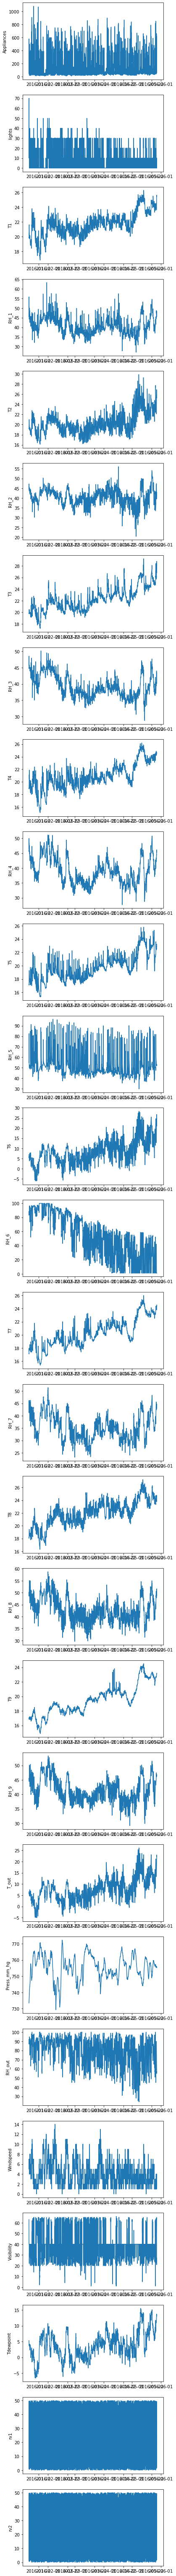

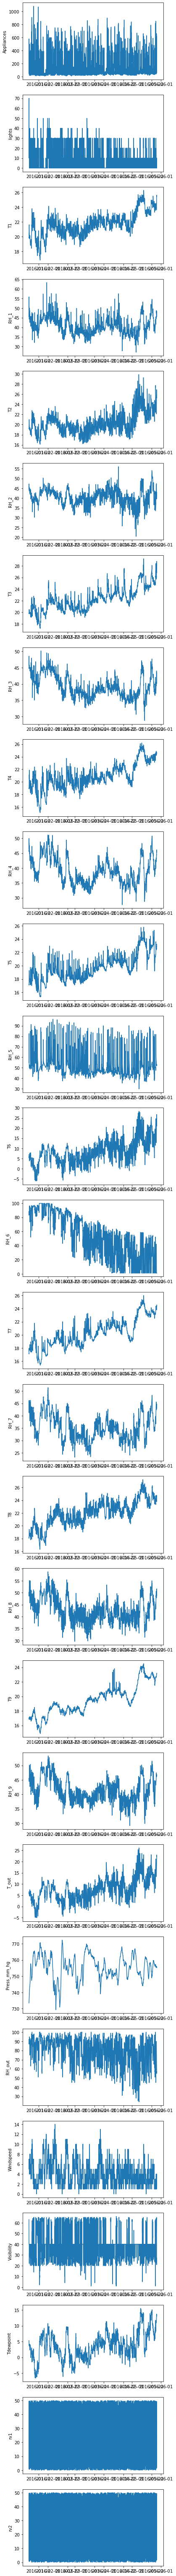

In [2]:
df = pd.read_csv('energydata_complete.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

fig = plot_data(df)
fig

### Generating extra features to describe time
weekday: number [0,6]\
weekstatus: binary describing weekend (1) or not (0)\
NSM: Number of Seconds from Midnight

These are used for filtering the data

In [3]:
weekday = np.zeros(len(df))
weekstatus = np.zeros(len(df))
NSM = np.zeros(len(df))
month = np.zeros(len(df))

for i, val in enumerate(df.index):
    weekday[i] = val.weekday()
    weekstatus[i] = (weekday[i] >= 5)  # False for workday, True for weekend
    NSM[i] = (val - val.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    month[i] = val.month

df['weekday'] = weekday
#df['week status'] = weekstatus
df['NSM'] = NSM
df['month'] = month


## Add n previous timepoints to the data

Here we add the result vector from "t-n" as part of the covariates. 


In [4]:
ns = [1, 6, 144] # Make a list in-case we want to skip some "n"
y = df['Appliances'].values # get y
for n in ns:
    temp = np.zeros_like(y)
    temp[n:] = y[:-n]
    df[f"t-{n}"]=temp
# Strip the first max(n) datapoints that now miss data
n = max(ns)
df = df[n:]

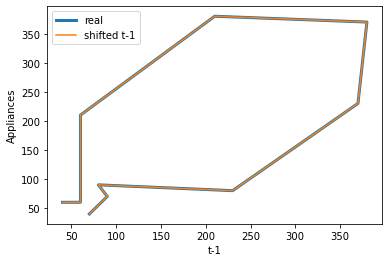

In [5]:
plt.figure()

# These two plots should be identical
plt.plot(df['t-1'][:10],df['Appliances'][:10], lw=3, label="real")
plt.plot(df['t-1'][:10], df['t-1'][1:11], label="shifted t-1") 
plt.xlabel('t-1')
plt.ylabel('Appliances')
plt.legend()
plt.show()

### Filtering data and making training/validation/test set

In [6]:
indices = (np.in1d(df.index.month, (1,2)))

# Train/validation/test
df_train = df[indices]
df_valid = df[(df.index.month==3)]
df_test = df[(df.index.month==4)]

X_train = np.array(df_train[df.columns[df.columns!='Appliances']])
y_train = np.array(df_train[df.columns[df.columns=='Appliances']])
X_test = np.array(df_test[df.columns[df.columns!='Appliances']])
y_test = np.array(df_test[df.columns[df.columns=='Appliances']])
X_valid = np.array(df_valid[df.columns[df.columns!='Appliances']])
y_valid = np.array(df_valid[df.columns[df.columns=='Appliances']])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = StandardScaler().fit(X_valid)
X_valid = scaler.transform(X_valid)
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

y_test_mean = y_test.mean()
y_valid_mean = y_valid.mean()
y_train_mean = y_train.mean()

y_train = y_train - y_train_mean
y_valid = y_valid - y_valid_mean
y_test = y_test - y_test_mean

In [7]:
# Check that the filter was correct
print(len(df[(df.index.month==1)])+ len(df[(df.index.month==2)]))
print(len(df_train))

6954
6954


### Correlations of covariates

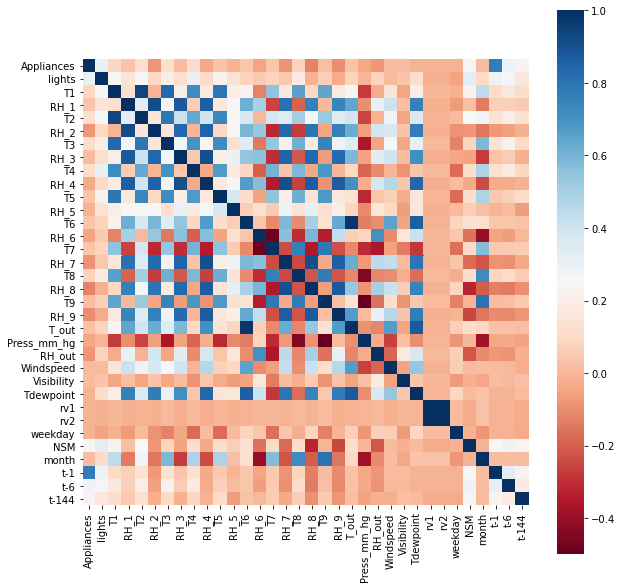

In [8]:
cor = df_train[df_train.columns].corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cor, square=True, xticklabels=True, yticklabels=True, cmap='RdBu')
plt.show()

## Neural Networks

### Feedforward Neural Network
The first neural network is actually not a RNN, but a feedforward network, where we include the input features t-n, which denotes the response variable from earlier time steps.

The network architecture consists of a number of dense layers each followed by a dropout layer.

### Hyper parameter tuning

Hyperparameter tuning of a NN model using either Random Search or Bayesian optimization:

The hyperparameters are:

1. Input layer size
2. Number of layers
3. Size of each layer
4. Regularization term (same for each layer)
5. Learning rate
6. Learning rate decay

The maximum values, minimum values and step size are chosen below in the method ```build_model```


# Next step might take a long time to run!!!

When ```trials = 1000``` the next step took 2 hours and 22 minutes to run.

In [9]:
## Building NN and yuning hyper parameters

# Number of different models tried in the tuning process
trials = 2000
# Number of initial randomly selected points in the tuning process
starting_points = 200

# Early stopping
es = EarlyStopping(monitor="val_loss",patience=5)

# Timer
LOG_DIR = f"{int(time.time())}"

def build_model(hp):
    
    # Model
    model = Sequential()
    
    # Building layers
    for i in range(hp.Int('n_layers',min_value=1,max_value=3)):
        model.add(Dense(hp.Int(f"units_{i+1}",min_value=50,max_value=1000,step=50), 
             activation='relu', 
             name=f"dense{i+1}",
             kernel_regularizer=regularizers.l2(hp.Float('l2',1e-6,1)),           
            )
        )
        model.add(Dropout(hp.Float(f"drop_out_rate",0,0.9,0.1),
                         name=f"dropout{i+1}"))
    
    
    model.add(Dense(1,activation='linear', name="outputlayer"))

    # ADAM optimizer, learning rate and decay is specified
    opt = tf.keras.optimizers.Adam(lr=hp.Float('lr',1e-4,1e-3), decay=hp.Float('decay',1e-6,1e-5))

    # The NN is compiled. A MSE loss function is used.
    model.compile(loss='mse',
           optimizer=opt,
           metrics='mse',
           )
    
    return model

## Tuner object
# tuner = RandomSearch(build_model,
#                      objective = 'val_mse',
#                      max_trials = trials,
#                      executions_per_trial = 1,
#                      directory = LOG_DIR
#                     )

tuner = BayesianOptimization(build_model,
                     objective = 'val_mse',
                     max_trials = trials,
                     executions_per_trial = 1,
                     seed = 123,
                     num_initial_points = starting_points,
                     alpha = 1e-4,  # 1e-4 by default
                     beta = 1,   # 2.6 by default. I don't think we want to explore much and rather find a local min
                     directory = LOG_DIR
                    )

# Tuner search
tuner.search(x=X_train,
             y=y_train,
             epochs = 3,
             validation_data=(X_valid,y_valid))

Trial 2000 Complete [00h 00m 05s]
val_mse: 4923.91162109375

Best val_mse So Far: 4485.64306640625
Total elapsed time: 15h 47m 08s
INFO:tensorflow:Oracle triggered exit


In [10]:
# Best selection of hyperparameters found from tuning
best_hp = tuner.get_best_hyperparameters()[0]
hp_folder = "best_hyper_params"
if not os.path.exists(hp_folder):
    os.mkdir(hp_folder)
filename = f"{hp_folder}/NN_hp_{trials}trials_{starting_points}init.pckl"
pickle.dump(best_hp, open(filename, 'wb'))
best_hp.values

{'n_layers': 2,
 'units_1': 350,
 'l2': 0.5608389229119826,
 'drop_out_rate': 0.30000000000000004,
 'lr': 0.0006885060825564662,
 'decay': 8.265256367092405e-06,
 'units_2': 750,
 'units_3': 200}

In [11]:
# Compiling the model using the best params
model = build_model(best_hp)

# The model is fitted to the training data and validated using the validation data. Variable number of epochs.
history = model.fit(X_train,y_train, epochs=20, verbose=0, validation_data=(X_valid,y_valid), callbacks=es)

# The predicted values are found using the test set
y_pred = model.predict(X_test)

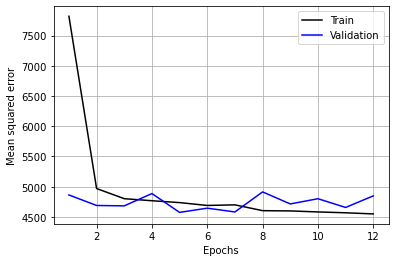

In [12]:
plt.figure()
plt.plot(np.arange(1,len(history.history['mse'])+1),history.history['mse'],'k-',label='Train')
plt.plot(np.arange(1,len(history.history['mse'])+1),history.history['val_mse'],'b-',label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid()
plt.legend()
plt.show()

In [13]:
# A summary of the used network
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 350)               11900     
_________________________________________________________________
dropout1 (Dropout)           (None, 350)               0         
_________________________________________________________________
dense2 (Dense)               (None, 750)               263250    
_________________________________________________________________
dropout2 (Dropout)           (None, 750)               0         
_________________________________________________________________
outputlayer (Dense)          (None, 1)                 751       
Total params: 275,901
Trainable params: 275,901
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Function that calculates the R^2 value
def coeff_determination(y_true, y_pred):
    SS_res =  np.sum(( y_true - y_pred )**2)
    SS_tot = np.sum(( y_true - np.mean(y_true) )**2 )
    return ( 1 - SS_res/SS_tot )

# Train and test score given by R^2
print('Train score: '+ str(coeff_determination(y_train,model.predict(X_train))))
print('Test score: '+ str(coeff_determination(y_test,y_pred)))

Train score: 0.6418721154399658
Test score: 0.5445299372953258


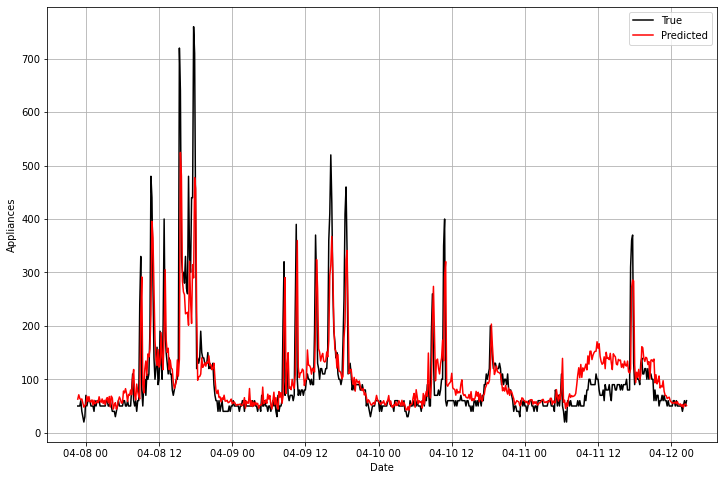

In [15]:
# A plot of real data and predicted data in time between two time intervals:

index_first = 1000
index_last = 1600

plt.figure(figsize=(12,8))
plt.plot(df_test.index[index_first:index_last],y_test[index_first:index_last]+y_test_mean,'k-', label='True')
plt.plot(df_test.index[index_first:index_last],y_pred[index_first:index_last]+y_test_mean,'r-', label='Predicted')
plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Appliances')
plt.show()

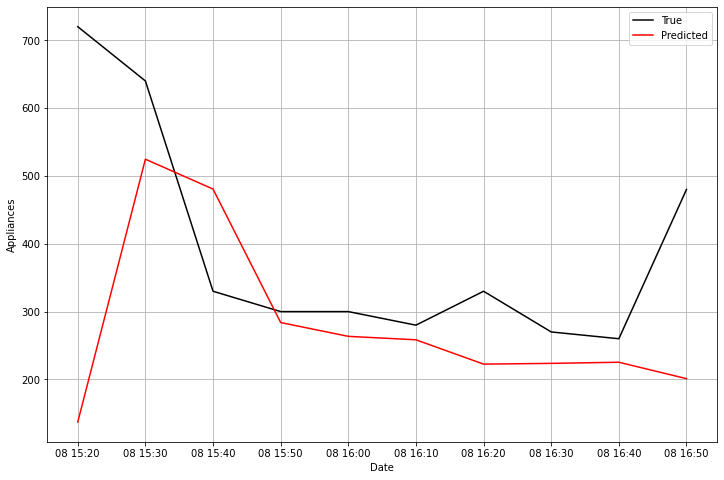

In [16]:
# A plot of real data and predicted data in time between two time intervals:

index_first = 1100
index_last = 1110

plt.figure(figsize=(12,8))
plt.plot(df_test.index[index_first:index_last],y_test[index_first:index_last]+y_test_mean,'k-', label='True')
plt.plot(df_test.index[index_first:index_last],y_pred[index_first:index_last]+y_test_mean,'r-', label='Predicted')
plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Appliances')
plt.show()

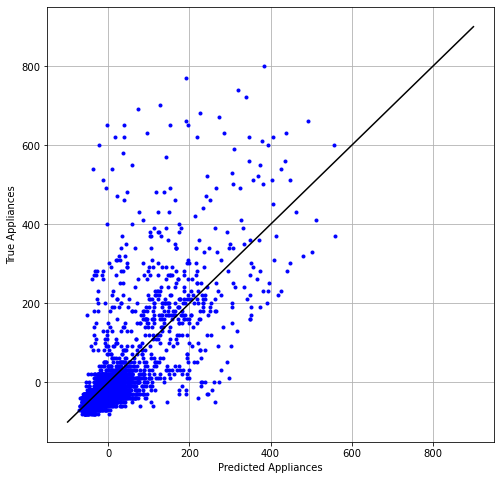

In [17]:
plt.figure(figsize=(8,8))
plt.plot(y_pred,y_test,'b.')
plt.plot([-100,900],[-100,900],'k-')
plt.grid()
plt.xlabel('Predicted Appliances')
plt.ylabel('True Appliances')
plt.show()

## Lime explaination of the model

In [18]:
# add a predictor function that adds the y_test_mean
def predictor(*args, **kwargs):
    return model.predict(*args, **kwargs)+y_test_mean

explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=df.columns[df.columns!='Appliances'], 
                                                   class_names=['Appliances'],
                                                   categorical_features=['weekday'],
                                                   verbose=True, mode='regression')
# Pick a high consumption point
i = 1101
exp = explainer.explain_instance(X_test[i], predictor, num_features=10)

Intercept 77.33108685150793
Prediction_local [266.78938739]
Right: 524.65857


In [19]:
exp.show_in_notebook(show_table=True)

In [20]:
# Pick a average/low consumption point
i = 100
exp = explainer.explain_instance(X_test[i], predictor, num_features=10)
exp.show_in_notebook(show_table=True)

Intercept 133.2057222118282
Prediction_local [90.47363142]
Right: 56.80586


In [21]:
exp.as_list()

[('-0.53 < t-1 <= -0.35', -57.55819327950209),
 ('T2 > 0.69', 14.975006296030582),
 ('RH_2 <= -0.69', 13.020146522746657),
 ('0.11 < T1 <= 0.69', -10.81474190884675),
 ('-0.65 < T3 <= 0.02', -7.661087912307627),
 ('t-144 > 0.02', 7.074409107161589),
 ('-0.04 < RH_9 <= 0.85', -5.3079630701449),
 ('Press_mm_hg > 0.74', -4.983001258446295),
 ('0.00 < NSM <= 0.87', 4.436194218617494),
 ('RH_out <= -0.47', 4.087140497210887)]

## Decision tree surrogacy

Here we are going to investigate what the most important feature is in the trained neural net by training a surrugate model on the output of the NN model. Then we investigate the tree to figure out what features are most important for the NN predictions.

In [22]:
# Sander's code here

# Retrain the model
# Compiling the model using the best params
model = build_model(best_hp)

# The model is fitted to the training data and validated using the validation data. Variable number of epochs.
_ = model.fit(X_train,y_train, epochs=20, verbose=0, validation_data=(X_valid,y_valid), callbacks=es)


# Set X train to original, but replace Y to the response of the network
s_X_train = X_train
s_Y_train = model.predict(X_train)

s_X_test = X_test
s_Y_test = model.predict(X_test)

In [23]:
clf = DecisionTreeRegressor(random_state=42)
clf.fit(s_X_train, s_Y_train)
y_hat_train = clf.predict(s_X_train)
y_hat_test = clf.predict(s_X_test)
train_err = np.average(np.sqrt((y_hat_train-s_Y_train)**2))
test_err = np.average(np.sqrt((y_hat_test-s_Y_test)**2))
print(f"Train MSE: {train_err}")
print(f"Test MSE: {test_err}")

Train MSE: 72.28503977589729
Test MSE: 66.21389702674067


In [24]:
print(f"Train score: {coeff_determination(s_Y_train, y_hat_train)}")
print(f"Train score: {coeff_determination(s_Y_test, y_hat_test)}")

Train score: -13907.000145023207
Train score: -8701.655219581628


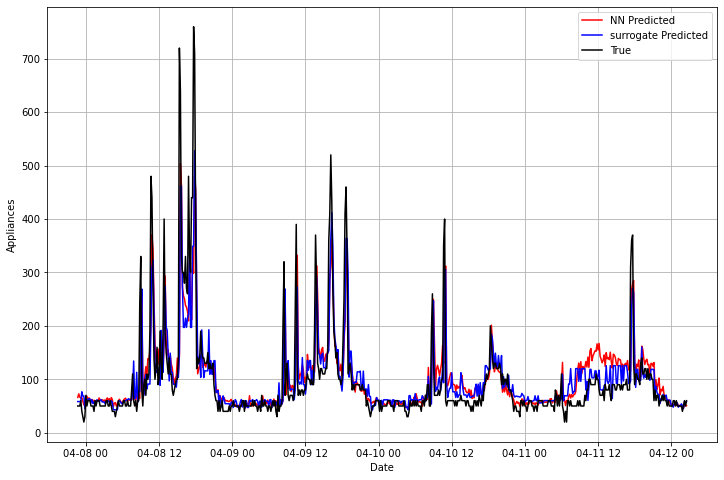

In [25]:
# A plot of real data and predicted data in time between two time intervals:

index_first = 1000
index_last = 1600

plt.figure(figsize=(12,8))
plt.plot(df_test.index[index_first:index_last],s_Y_test[index_first:index_last]+y_test_mean,'r-', label='NN Predicted')
plt.plot(df_test.index[index_first:index_last],y_hat_test[index_first:index_last]+y_test_mean,'b-', label='surrogate Predicted')
plt.plot(df_test.index[index_first:index_last],y_test[index_first:index_last]+y_test_mean,'k-', label='True')

plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Appliances')
plt.show()

In [26]:
# Here we print the features in order of imporance
feature_importances = clf.tree_.compute_feature_importances()
idx = np.argsort(feature_importances)[::-1]
keys = df.keys()[1:]
for i in idx:
    print(f"{keys[i]}: {feature_importances[i]}")

t-1: 0.9615051273555956
lights: 0.003880744910507791
NSM: 0.00348488385583387
t-6: 0.002733630754375334
RH_8: 0.0020264726631140646
RH_2: 0.001982998929677311
T5: 0.00180888167529437
T9: 0.0017543085545131036
t-144: 0.0017188381256981469
RH_1: 0.0016648267140964472
RH_5: 0.0015395036203610887
month: 0.0014393875656879668
RH_out: 0.0013670853514575298
T3: 0.0012560588565061087
T2: 0.0010771656250702843
T4: 0.0008494072793652666
T7: 0.0008171812992735016
T8: 0.0007683218789734313
RH_7: 0.0007413387406061934
RH_9: 0.0007199050936889642
Press_mm_hg: 0.0006634625457187949
Tdewpoint: 0.0006175859524525126
Windspeed: 0.0005930182172755704
RH_3: 0.0005850783317153585
weekday: 0.0005833186235754302
T1: 0.0005721427826159359
rv1: 0.0005298493119077646
rv2: 0.0005182031205213052
RH_4: 0.0004994980714553713
T6: 0.0004965146549424461
T_out: 0.00042489148028988446
RH_6: 0.00040212286011820684
Visibility: 0.0003782451977151278


## Random forrest

In [27]:
# Youngrong's code her

## A randomforest model is made. All the ranges of the parameters used for the model are specified.
## Hyperparameters are tunned by gridsearchCV on validation data(Month==3)

model = RandomForestRegressor()

# Range of the gridsearch for RF hyperparameters
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 20],
    'max_features': ['auto','sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5],
    'n_estimators': [100, 300, 500, 1000]
}

### Grid search

In [28]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2)

# Validation with the data to find the best set of hyperparameters
grid_search.fit(X_valid,y_valid.ravel())

# A summary of the chosen pararmeters
print(grid_search.best_params_)

# The model is fitted to the training data and validated using the validation data.
rf = model.set_params(**grid_search.best_params_)

rf.fit(X_train, y_train.ravel())

Fitting 3 folds for each of 96 candidates, totalling 288 fits
{'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=500)

### Random Search

In [29]:
random_search = RandomizedSearchCV(estimator = model, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1)

# Validation with the data to find the best set of hyperparameters
random_search.fit(X_valid,y_valid.ravel())

# A summary of the chosen pararmeters
print('Best parameter:' +str(random_search.best_params_))

# The model is fitted to the training data and validated using the validation data.
rf = model.set_params(**random_search.best_params_)

rf.fit(X_train, y_train.ravel())

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best parameter:{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}


RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5)

### Load the RF model

In [30]:
# save the model to disk
filename = 'RF_model.sav'
pickle.dump(rf, open(filename, 'wb'))
# load the model from disk
#rf = pickle.load(open(filename, 'rb'))

In [31]:
# The predicted values are found using the test data
y_pred = rf.predict(X_test)

print('Train score: '+ str(coeff_determination(y_train.ravel(),rf.predict(X_train))))
print('Test score: '+ str(coeff_determination(y_test.ravel(),y_pred)))

Train score: 0.5663635849710664
Test score: 0.4578323525694791


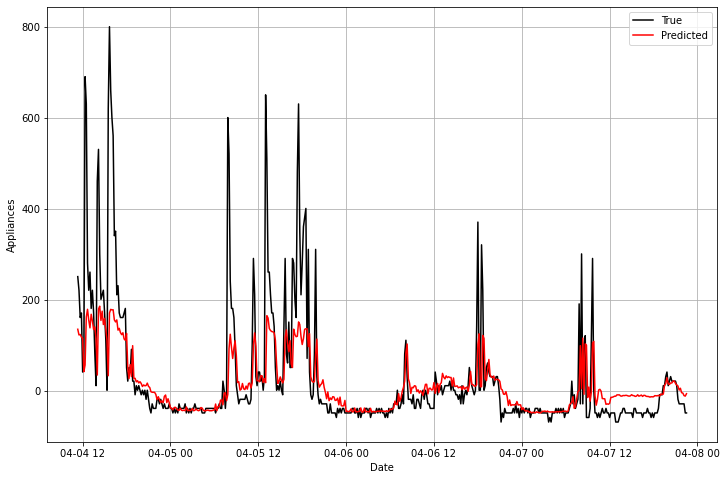

In [32]:
# A plot of real data and predicted data in time between two time intervals:

index_first = 500
index_last = 1000

plt.figure(figsize=(12,8))
plt.plot(df_test.index[index_first:index_last],y_test[index_first:index_last],'k-', label='True')
plt.plot(df_test.index[index_first:index_last],y_pred[index_first:index_last],'r-', label='Predicted')
plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Appliances')
plt.show()

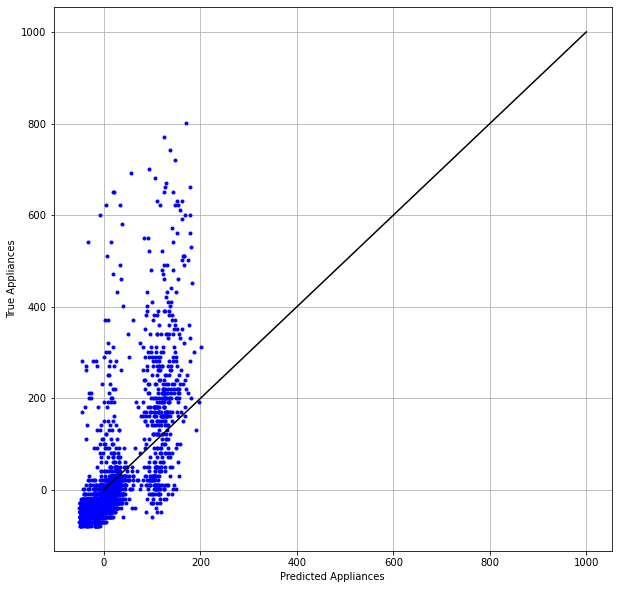

In [33]:
plt.figure(figsize=(10,10))
plt.plot(y_pred,y_test,'b.')
plt.plot([0,1000],[0,1000],'k-')
plt.grid()
plt.xlabel('Predicted Appliances')
plt.ylabel('True Appliances')
plt.show()